In [37]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import json
from pathlib import Path
from pprint import pprint
import numpy as np

import configparser

import matplotlib.pyplot as plt 
import seaborn as sns

from matplotlib_venn import venn2, venn3

from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()

import sys
sys.path.append("../")
from _helpers import *

In [60]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=2)

In [30]:
# Load config
root = Path('../../')
Config = configparser.ConfigParser()
Config.read(str(root / 'config.cnf'))

queries = root / Config.get('input_files', 'queries')
queries = load_queries(str(queries))

tweets = root / Config.get('output_files', 'tweets')
twitter_urls = root / Config.get('output_files', 'twitter_urls')
altmetric_urls = root / Config.get('output_files',  'altmetric_urls')

summary_altmetric = root / Config.get('output_files',  'summary_altmetric')

twitter_urls = load_urls(twitter_urls)
altmetric_urls = load_altmetric(altmetric_urls)

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [62]:
df = pd.DataFrame()
df['Total URLs'] = altmetric_urls.venue_short.value_counts()
df['Relevant URLs'] = altmetric_urls.groupby("venue_short").relevant.sum()

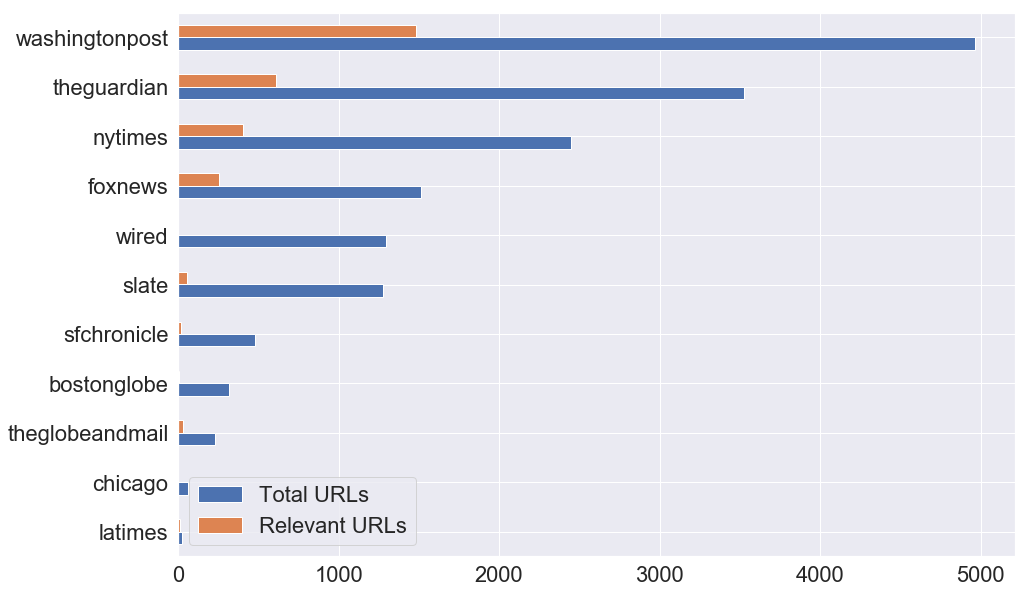

In [64]:
df.astype(int).sort_values(by="Total URLs", ascending=True).plot(kind="barh")

In [23]:
df = altmetric_urls[(altmetric_urls['clean_url'].notnull()) & (altmetric_urls.relevant == True)]
am_urls_per_source = df.groupby("venue_short")['clean_url'].apply(lambda x: set(x.unique()))

df = twitter_urls[(twitter_urls['cleaned_url'].notnull()) & (twitter_urls.relevant == True)]
tw_urls_per_source = df.groupby("venue")['cleaned_url'].apply(lambda x: set(x.unique()))

In [32]:
df = pd.DataFrame(columns=['Twitter', 'Altmetric', 'both'])
for ix, tw_urls in tw_urls_per_source.iteritems():
    try:
        tw = len(tw_urls)
        if ix in am_urls_per_source:
            am_urls = am_urls_per_source[ix]
            am = len(am_urls)
            both = len(tw_urls.intersection(am_urls))
        else:
            am = 0
            both = 0
        df.loc[ix] = [tw, am, both]
    except:
        raise
df.index.name = "venue"
df.sort_values(by="both", inplace=True)
df.to_csv(summary_altmetric)
df

,Twitter,Altmetric,both
venue,,,
slate,219,53,1
wired,255,1,1
bostonglobe,226,4,3
sfchronicle,325,19,5
latimes,2065,10,10
theglobeandmail,176,24,23
foxnews,3474,253,231
washingtonpost,4617,593,315
nytimes,4528,342,318


In [36]:
am_all_urls = set().union(*am_urls_per_source)
tw_all_urls = set().union(*tw_urls_per_source)

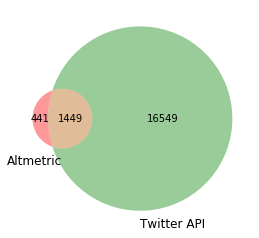

In [40]:
venn2([am_all_urls, tw_all_urls], set_labels = ["Altmetric", "Twitter API"])